In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import label_binarize, StandardScaler
from scipy import signal

# Block III: Tutorial on Principle Component Analysis

## Introduction

In this tutorial, we will take a look at three related techniques for dimensionality reduction: Principle Component Analysis (PCA), Kernel-PCA and Independent Component Analysis (ICA). For each method, we will give a short recap at the beginning of the respective section.

We would like to give credit to Prof. Vanessa Gòmez Verdejo (Universidad Carlos III) whose notebook inspired this.

## Notation

We will use $\mathbf{X} = [\mathbf{x_1}, ..., \mathbf{x_n}] \in \mathbb{R}^m$ to denote the samples with labels $\mathbf{y} = [y_1, ..., y_n]^T$. $\mathbf{S}$ denotes the data covariance matrix of $\mathbf{X}$.


## 1. Principal Component Analysis

Principal component analysis (PCA) lets us find the k-dimensional representation of the data that maximizes the variance of the data. Hence, we can drastically reduce the dimensionality of the data while maintaining and explaining the most important properties of the samples. As you have seen in the lecture, we iteratively find the normalized eigenvectors $\mathbf{u_1}, ..., \mathbf{u_k} \in \mathbb{R}^m$ of the covariance matrix of $\mathbf{X}$, $\mathbf{S}$, that corresponds to the largest eigenvalues. This gives us the projection matrix $\mathbf{U} = [\mathbf{u_1}, ..., \mathbf{u_k}] \in \mathbb{R}^{m \times k}$. You can read more about PCA in Bishop's book, chapter 12.1.

We will consider images as our working example, more precisely the `Olivetti Faces` dataset, which was created in the early 90s by AT&T Labs. It contains ten different 64x64 portraits from 40 subjects, each one with different ambient conditions and facial details. All images were taken frontally against a dark, homogeneous background while the subject were standing upright. Let's first download the dataset.

In [2]:
# Download and load as numpy arrays
print("This might take some time for the first time")
olivetti_people = fetch_olivetti_faces()

# Get dimensions for plotting
n_samples, portrait_h, portrait_w = olivetti_people.images.shape

# We use the pixel intensities stacked up as a vector ignoring 2d spatial information
X = olivetti_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
Y = olivetti_people.target
n_classes = np.unique(Y).shape[0]

print("Dataset size information:")
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

This might take some time for the first time
Dataset size information:
n_features: 4096
n_classes: 40


To account for the different lightening conditions, we normalize the data. As usual, we split into training, test, and validation sets.

CPU times: user 546 ms, sys: 10 ms, total: 556 ms
Wall time: 558 ms


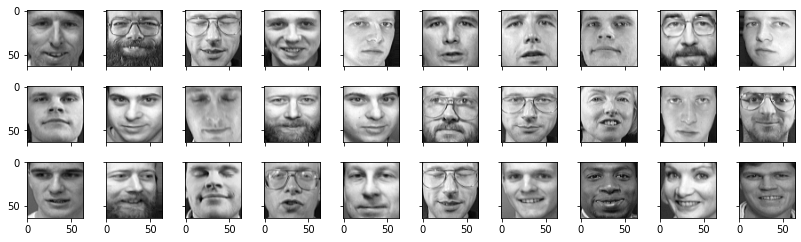

In [3]:
%%time
nrows = 3
ncols = 10
index_matrix = np.random.randint(low=0, high=X.shape[0], size=(nrows, ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(1.8*ncols, 2.4*nrows))
for i in range(nrows):
    for j in range(ncols):
        index = index_matrix[i][j]
        axs[i][j].imshow(X[index].reshape(portrait_h, portrait_w), cmap="gray")
plt.subplots_adjust(left=-0.3, right=0.3, bottom=0.5, top=0.9, hspace=0.35)

In [4]:
# Preprocessing
# Fix the random seed so that the results are comparable across different runs
np.random.seed(1)

# Split into a training set and a test set using a stratified k fold

# Split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

# Split into a training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.333)

# Normalize the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to the validation and test data
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Apply the same transformation in a one-vs-all fashion, yields a matrix
set_classes = np.unique(Y)
Y_train_bin = label_binarize(Y_train, classes=set_classes)

print("Number of training samples: {}".format(X_train.shape[0]))
print("Number of validation samples: {}".format(X_val.shape[0]))
print("Number of test samples: {}".format(X_test.shape[0]))

Number of training samples: 200
Number of validation samples: 100
Number of test samples: 100


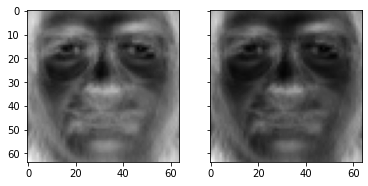

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
axs[0].imshow(scaler.scale_.reshape(portrait_h, portrait_w), cmap="gray")
axs[1].imshow(scaler.var_.reshape(portrait_h, portrait_w), cmap="gray")

Let's have a look at some of the origial portaits. To speed up the process, we provide a function to display images in a grid.

In [6]:
def plot_gallery(images, titles, h, w, n_row=4, n_col=10):
    """Helper function to plot an array of images of dimensions (h x w) in a grid."""
    plt.figure(figsize=(1.8*n_col, 2.4*n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([])
        plt.yticks([])

CPU times: user 559 ms, sys: 10.7 ms, total: 569 ms
Wall time: 570 ms


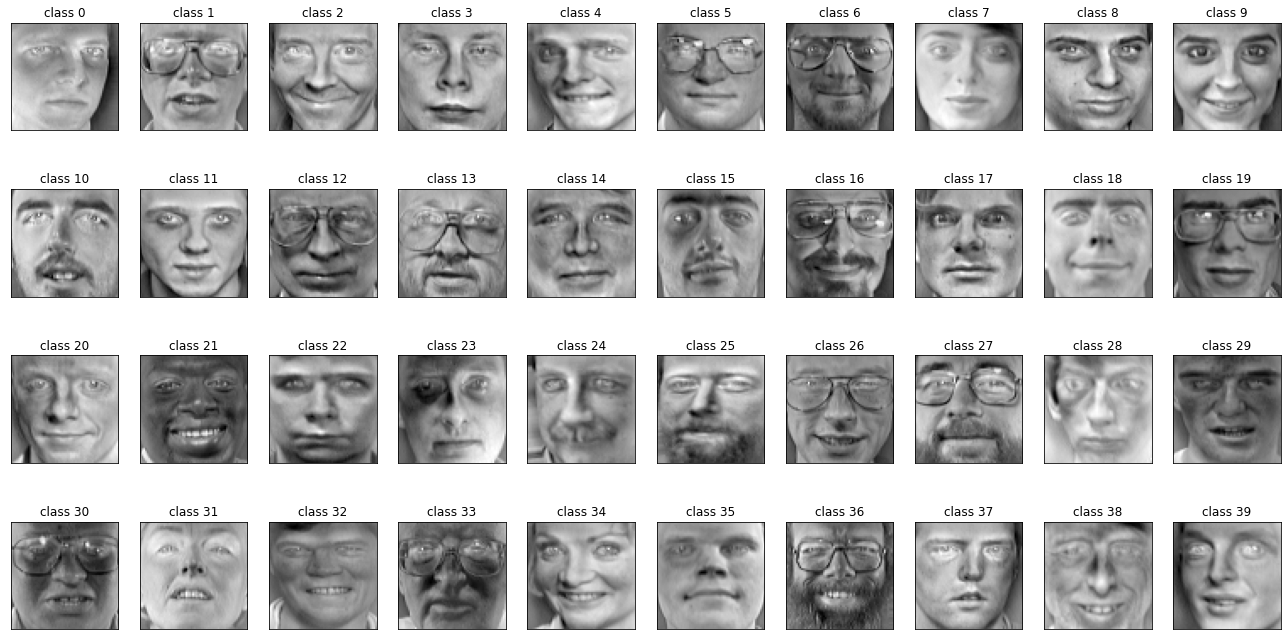

In [7]:
%%time

# Plot one portrait of every subject
titles = ["class "+ str(c) for c in set_classes]
ind_faces = [np.where(Y_train == c)[0][0] for c in set_classes]

plot_gallery(X_train[ind_faces, :], titles, portrait_h, portrait_w)

Let us do the following:
- Find the projection matrix $U$ for $k=100$.
- Obtain the projected data `X_train_proj`, `X_val_proj` and `X_test_proj`

Checkout the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) model from the sklearn toolbox and the [sklearn PCA user guide](https://scikit-learn.org/stable/modules/decomposition.html#exact-pca-and-probabilistic-interpretation)

In [8]:
from sklearn.decomposition import PCA
n_pca_components = 100

# Find the dimensionality reduction using PCA with n_pca_components components
pca = PCA(n_components=n_pca_components)
X_train_proj = pca.fit_transform(X_train)
X_val_proj = pca.transform(X_val)
X_test_proj = pca.transform(X_test)

assert  X_train_proj.shape == (X_train.shape[0], n_pca_components)

In [9]:
pca.components_.shape

(100, 4096)

In [10]:
# Check the orthogonality eigen vectors
assert np.isclose(pca.components_[0, :] @ pca.components_[90, :], 0)

# Check orthonormality i.e unit length of eigen vectors
assert(np.isclose(pca.components_[99, :] @ pca.components_[99, :], 1.0))

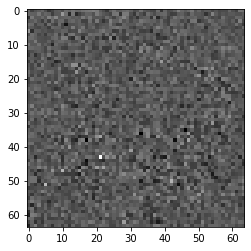

In [11]:
# Since we have already removed the mean, this is expected
plt.imshow(pca.mean_.reshape(64, 64), cmap="gray")

In [12]:
# Check identity property
assert np.allclose(np.diag(pca.components_ @ pca.components_.T), 1.0)

So if the reduced representation really contains most of the properties of the original data, can we reconstruct an image to see how well we are doing? Recall that $\mathrm{\mathbf{U}}$ consists of normalized eigenvectors of the symmetric matrix $\mathbf{S}$. One property of such an orthogonal matrix is $\mathrm{\mathbf{U}}\mathrm{\mathbf{U}}^T = \mathrm{\mathbf{I}}$ which means that $\mathbf{X}\mathrm{\mathbf{U}}\mathrm{\mathbf{U}}^T = \tilde{\mathbf{X}}\mathrm{\mathbf{U}}^T=\mathbf{X}$ i.e the reverse transformation is given by $\mathrm{\mathbf{U}}^T$. Neat! Take the reduced sample we've indicated, let's try to reconstruct the image using 1, 10, 50 and all the eigenvectors and plot the results. Sklearn won't let us use fewer eigenvectors out of the box, so you will have to use the above (or something else) to make it happen.

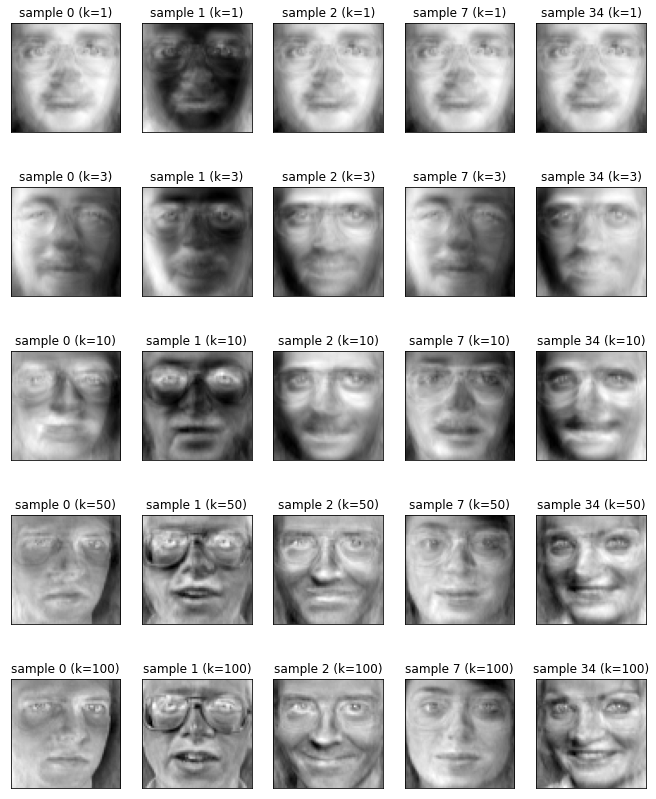

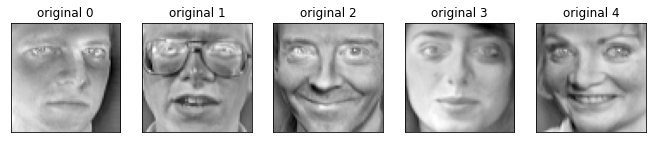

In [13]:
subjects = [0, 1, 2, 7, 34]
ind_fav_samples = [np.where(Y_train == c)[0][0] for c in subjects]

# Reconstruct the samples indexed by ind_fav_samples and plot the results
pca_comp = pca.components_
X_train_rec1 = np.dot(X_train_proj[ind_fav_samples, 0:1], pca_comp[0:1])
X_train_rec3 = np.dot(X_train_proj[ind_fav_samples, 0:3], pca_comp[0:3])
X_train_rec10 = np.dot(X_train_proj[ind_fav_samples, 0:10], pca_comp[0:10])
X_train_rec50 = np.dot(X_train_proj[ind_fav_samples, 0:50], pca_comp[0:50])
X_train_rec_all = pca.inverse_transform(X_train_proj)[ind_fav_samples]

X_train_rec = np.concatenate([X_train_rec1, X_train_rec3, X_train_rec10, X_train_rec50, X_train_rec_all], axis=0)
titles = sum([[f"sample {c} (k={k})" for c in subjects] for k in [1, 3, 10, 50, n_pca_components]], [])
plot_gallery(X_train_rec, titles, portrait_h, portrait_w, n_row=5, n_col=5)
plot_gallery(X_train[ind_fav_samples], [f"original {i}" for i in range(5)], portrait_h, portrait_w, n_row=1, n_col=5)


We've gotten pretty close to the original images, haven't we? And all of these with a simple linear transformation! We might want to investigate that transformation a little closer. The value $\tilde{x}_{i,j}$ of the j-th component in the reduced representation of sample $\mathbf{x}_i$ is obtained from the j-th eigenvector as $\tilde{x}_{i,j} = \mathbf{x_i}\mathbf{u_j}$. The elements of the eigenvector $\mathbf{u_j}$ can therefore be interpreted as weights indicating how much each pixel contributes to the j-th dimension in the reduced representation. Let's plot the first 20 eigenvectors!

(20, 4096)


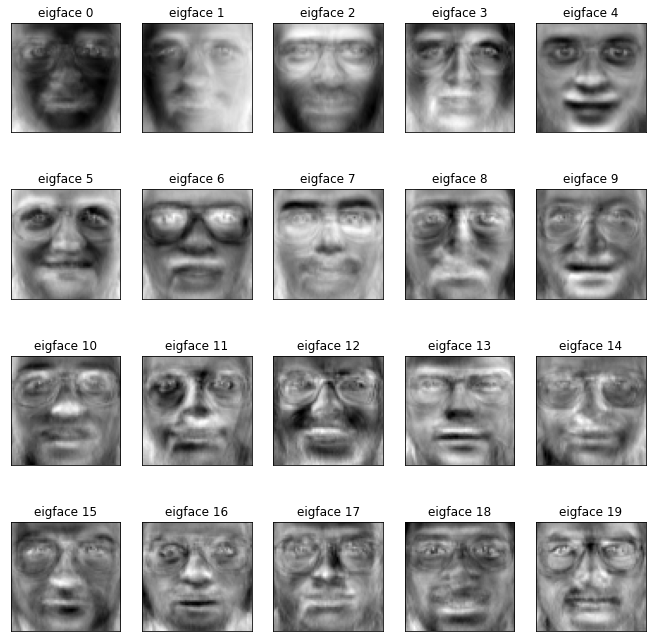

In [14]:
num_eigfaces = 20
eigenfaces = np.stack(pca_comp[:num_eigfaces])
titles = ["eigface {}".format(i) for i in range(num_eigfaces)]
print(eigenfaces.shape)
plot_gallery(eigenfaces, titles, portrait_h, portrait_w, n_row=4, n_col=5)

...those look like faces! That's why these are known as eigenfaces to computer vision people. If you've plotted the eigenfaces in order, you can see how they start out as a rather prototypical human face and become more and more specific to certain groups of subjects. This is because the variance along each dimension decreases as the eigenvalues decrease by which the eigenfaces are ordered. To see this, let's plot the estimated variance per component.

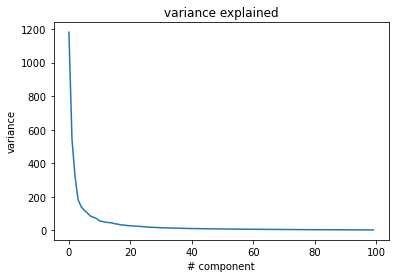

In [15]:
# Plot the estimated variance as a function of the position of the associated component
plt.figure()
plt.plot(pca.explained_variance_)
plt.xlabel("# component")
plt.ylabel("variance")
plt.title("variance explained")
plt.show()

This chart tells us that the lion's share of the variance is already accounted for by roughly the first 10 components. The images above reconstructed from the first 10 eigenvectors only look rather sketchy to the human eye, but that's not a good reference. A better way to check the quality of the 10-d representation would be to train a classifier and have it distinguish the people depicted. After all, an image of you looks similar regardless of ambient light or pose, so the majority of the variation in our data set should occur because of the difference in a given subject. We have introduced support vector machines in previous tutorial, so let's use that!

Text(0.5, 1.0, 'performance')

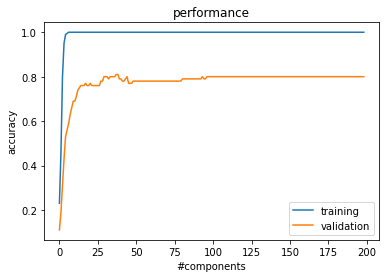

In [16]:
from sklearn.svm import SVC

# Implement a SVM classifier, obtain the predictions using the first 1, ..., n_pca_components components
# and compute the errors

def classify_with_features(X_train, Y_train, X_val, Y_val):
    """fits SVM model on (X_train, Y_train)
       calculates the error on (X_val, Y_val)
       returns the training and validation error
    """
    svm = SVC(kernel="linear")
    svm.fit(X_train, Y_train)
    return (svm.score(X_train, Y_train), svm.score(X_val, Y_val))
    
    
def calculate_accuracies(X_train, Y_train, X_val, Y_val):
    """make predictions for any number of initial features
       returns the list of training and validation errors
    """
    n_features = X_train.shape[0]
    train_errs = []
    val_errs = []
    for i in range(1, n_features):
        (te, ve) = classify_with_features(X_train[:, :i], Y_train, X_val[:, :i], Y_val)
        train_errs.append(te)
        val_errs.append(ve)
    return (train_errs, val_errs)

(train_score, val_score) = calculate_accuracies(X_train_proj, Y_train, X_val_proj, Y_val)

plt.figure()
plt.plot(train_score, label="training")
plt.plot(val_score, label="validation")
plt.xlabel("#components")
plt.ylabel("accuracy")
plt.legend(["training", "validation"], loc=4)
plt.title("performance")
    

Now, there's only one question that remans: what's the optimal number of features we should use?

In [17]:
# Select optimal number of features and compute the test accuracy
n_max = np.argmax(val_score)
svm = SVC(kernel="linear")
svm.fit(X_train_proj[:, :n_max], Y_train)
test_score = svm.score(X_test_proj[:, :n_max], Y_test)
print("We get the best performance with {} features given a test accuracy of {}".format(n_max, test_score*100))


We get the best performance with 37 features given a test accuracy of 87.0


## 2. Kernel Principal Component Analysis

Suppose we have some data whose features are non-linearly related. In standard PCA, we used the relations among features to obtain a reduced representation using a linear transformation. In the presence of non-linear relationships, this will not work. If we'd apply a non-linear feature map $\phi$, though, could we do PCA in the feature space? Yes, we can! Kernels to the rescue!

Let's paraphrase a bit how it works. We want a method that does not explicitly work in feature space but instead only uses a kernel $k$, because we don't know $\phi$. This means that we want to have dot products $\phi(\mathbf{x})\phi(\mathbf{x}')$ everywhere so we can apply the kernel trick. Since we can pose PCA as the problem of finding the orthogonal projection onto a subspace that minimizes the squared error, we can apply the Representer Theorem, massage the problem a bit and obtain an eigen-problem $\mathbf{Ka}=\lambda\mathbf{a}$ for the Gram Matrix $\mathbf{K}$ associated with $\mathbf{X}$ yielding eigenvectors $\mathbf{v_1}, ..., \mathbf{v_k}$. We obtain the projections $\tilde{\mathbf{x}}_i = \sum_{i=1}^k K_i \mathbf{v_i}$. Again, you can read up the details in Bishop's book, chapter 12.3.

We're going to use a toy dataset in 2 dimensions where the data points belong to one of two circles. For your convenience, we provide you with a function to plot this dataset. 

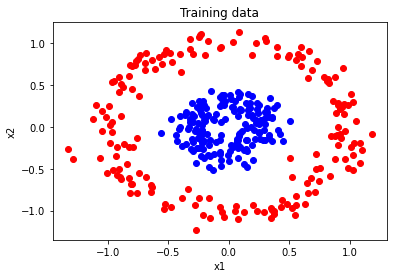

In [18]:
def plot_circles(X, Y):
    index_c1 = Y == 0
    index_c2 = ~index_c1
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.plot(X[index_c1, 0], X[index_c1, 1], "ro")
    plt.plot(X[index_c2, 0], X[index_c2, 1], "bo")
    
# Generate ring data set
from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=500, noise=0.1, factor=0.3, shuffle=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

nz = StandardScaler()
plt.figure()
plt.title("Training data")
plt.xlabel("x1")
plt.ylabel("x2")
plot_circles(X_train, Y_train)
plt.show()


The relationship between the features is clearly non-linear. Say we'd like to use a linear support vector classifier to tell the red and blue classes apart. We could try to project the data into some other space where the points are maybe easier to seperate. Do you think PCA is going to work? Despite major suspicions, we should give it a try. But we should also use something better: Kernel-PCA. Let's do two projections of both the training and test data using PCA and KPCA, fit a two linear SVM on both sets of projected training data and compute the respective accuracies on the test data set. 

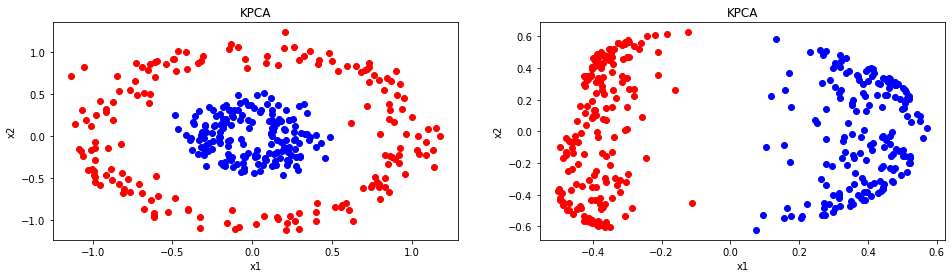

Accuracy with PCA: 66.0
Accuracy with KPCA: 100.0


In [19]:
from sklearn.decomposition import KernelPCA

n_component = 2

# Project the data
pca = PCA(n_components=2)
X_train_lin = pca.fit_transform(X_train)
X_test_lin = pca.transform(X_test)

kpca = KernelPCA(n_components=2, kernel="rbf", gamma=2)
X_train_ker = kpca.fit_transform(X_train)
X_test_ker = kpca.transform(X_test)

# Plot projection
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title("KPCA")
plot_circles(X_train_lin, Y_train)
plt.subplot(1, 2, 2)
plt.title("KPCA")
plot_circles(X_train_ker, Y_train)
plt.show()

# Train classifier
svm = SVC(kernel="linear")
svm.fit(X_train_lin, Y_train)
score_lin = svm.score(X_test_lin, Y_test)
svm.fit(X_train_ker, Y_train)
score_ker = svm.score(X_test_ker, Y_test)
print("Accuracy with PCA: {}".format(score_lin*100))
print("Accuracy with KPCA: {}".format(score_ker*100))

This confirms our suspicions: ordinary PCA can't do anything to help us separate the two classes. In contrast KPCA can due to the underlying non-linear transformation of the data. Ofcourse the stark difference between the performances is because we're using a contrived example. You can play a little with the parameters `factor` and `noise` of the data generating function `make_circles` and with the `gamma` parameter of KPCA to see if you can obtain diffferent results.

## 3. Independent Component Analysis

Before we talk about independent Component Analysis (ICA) we need to talk about PCA again. The PCA algorithm can be motivated and derived in different ways such as being the projection maximizing the variance as stated above. There's a varIant termed probablistic PCA: say, we introduce latent variables $\mathbf{z}_i \in \mathbb{R}^k$ that give the coordinates of a sample $\mathbf{x}_i \in \mathbb{R}^m$ in the reduced representation (which we want to find). If we assume that the density of the latent variables $p(\mathbf{z})$ is Gaussian and the datapoints $\mathbf{x}_i$ are simply a noisy linear transformation of the latent variables $\mathbf{z}_i$, we can obtain the latent variables by a mazimum likelihood estimate. That's all the details we need, though if you're curious, you might want to look at chapter 12.2 in Bishop's book.

The assumption of Gaussian latent variables may be problematic for certain data. So let's generalize the probabilistic PCA model by allowing a non-Gaussian prior $p(\mathbf{z})$ with the addition that the coordinates of the latent variable representation be independent - hence the name. More details can be found in Bishop 12.4.1 or in the [sklearn user guide](https://scikit-learn.org/stable/modules/decomposition.html#ica).

"What could such model be good for?", you might ask. Excellent question! 

Suppose there are $k$ senders in a room where each sender $j$ sends the signal $z_{i,j}$ at time $i$. There are also $m$ receivers where each receiver $l$ records the received signal $x_{i,l} = \sum_{j=1}^k c_{l,j}z_{i,j}$ i.e a fixed mixture of the signal is sent. We only know the recorded signal $\mathbf{X}$ and from those we would like to recover the original signals $\mathbf{Z}$. Too bad we don't know those mixing coefficients $\mathbf{C}$! That's why this task is called the "blind source seperation" problem. Say, we don't care about the time of the signal, so ICA could be a good fit for this task.

First things first: we need a new toy dataset. Let's generate 3 visibly distinct signals: a sinusoidal, a square, and a sawtooth signal. Just for the fun of it, we add some noise. Lastly, we mix the signals together according to some fixed mixing coefficients. 

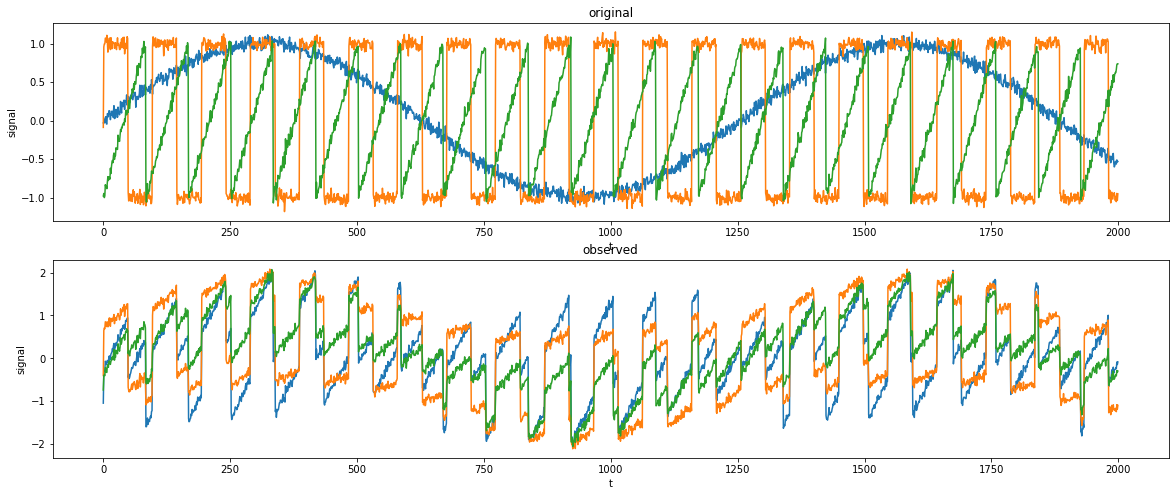

In [20]:
n_samples = 2000
t = np.linspace(0, 10, n_samples)

sine = np.sin(t)
square = np.sign(np.sin(13*t))
sawtooth = signal.sawtooth(15*t)

Z_or = np.stack((sine, square, sawtooth))
Z_or += 0.05*np.random.normal(size=Z_or.shape)

plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.title("original")
plt.xlabel("t")
plt.ylabel("signal")
plt.plot(Z_or[0])
plt.plot(Z_or[1])
plt.plot(Z_or[2])

C = np.array([[0.3, 0.7, 1.0], [0.7, 1.0, 0.3], [1.0, 0.3, 0.7]])
X = C @ Z_or

plt.subplot(2, 1, 2)
plt.title("observed")
plt.xlabel("t")
plt.ylabel("signal")
plt.plot(X[0])
plt.plot(X[1])
plt.plot(X[2])
plt.show()

Now use ICA to hopefully recover the original, independent signals. We will use the [Fast ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA) implementation from Sklearn. As a benchmark let's compare ICA to the decomposition obtained from PCA both with three components.

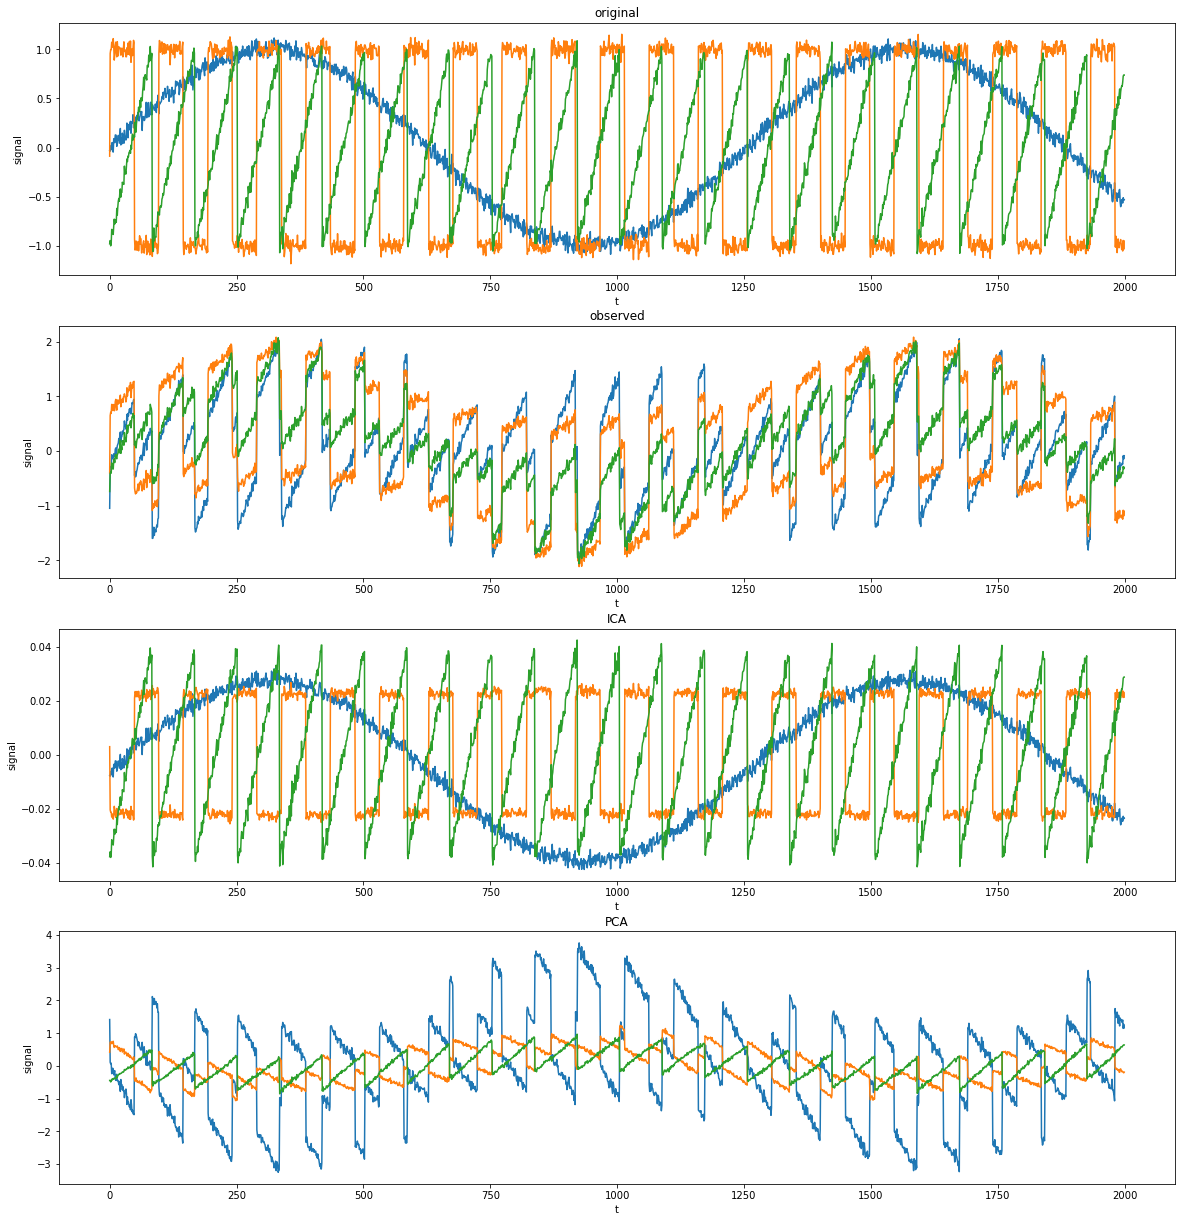

In [21]:
from sklearn.decomposition import FastICA, PCA

ica = FastICA(n_components=X.shape[0], max_iter=2000)
Z_ica = ica.fit_transform(X.T)

pca = PCA(n_components=X.shape[0])
Z_pca = pca.fit_transform(X.T)

plt.figure(figsize=(20, 15))
plt.subplot(4, 1, 1)
plt.title("original")
plt.xlabel("t")
plt.ylabel("signal")
plt.plot(Z_or[0])
plt.plot(Z_or[1])
plt.plot(Z_or[2])

plt.subplot(4, 1, 2)
plt.title("observed")
plt.xlabel("t")
plt.ylabel("signal")
plt.plot(X[0])
plt.plot(X[1])
plt.plot(X[2])

plt.subplot(4, 1, 3)
plt.title("ICA")
plt.xlabel("t")
plt.ylabel("signal")
for i in range(3):
    plt.plot(Z_ica[:, i])

plt.subplot(4, 1, 4)
plt.title("PCA")
plt.xlabel("t")
plt.ylabel("signal")
for i in range(3):
    plt.plot(Z_pca[:, i])

plt.subplots_adjust(top=1.2)
plt.show()

In [22]:
ica.components_, C, ica.mixing_

(array([[-0.02702267,  0.00808375,  0.03599157],
        [-0.00616095, -0.0233827 ,  0.01786716],
        [ 0.04194429, -0.03153802,  0.00904177]]),
 array([[0.3, 0.7, 1. ],
        [0.7, 1. , 0.3],
        [1. , 0.3, 0.7]]),
 array([[  8.96152174, -30.75279614,  25.09752218],
        [ 20.49343269, -44.64481209,   6.64531109],
        [ 29.90979705, -13.06209823,  17.35081563]]))

That's very accurate! In comparison, we can see that PCA performs very poorly. Yet, would that always be the case? You can try to modify the phase parameters of the input signal and mixing coefficients to see if the difference between ICA and PCA is always as clear-cut.

### Credit
This notebook was created by UdS ML21 tutors and modified by ML22 team. Thanks to Adrián Javaloy Bornás and team.